In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Table Of Content

* [Introduction](#section-one)
* [1. Data Understanding](#dataunderstanding)
    -  [Nomenclature of Dataset](#nomenclature)
    -  [Dataset Information](#info)
    -  [Statistic Descriptive](#statdesc)
* [2. EDA](#eda)
    -  [Numerical Features](#numfeat)
    -  [Categorical Features](#catfeat)
    -  [Correlation matrix](#corr)
    -  [Target Distribution](#target)
    -  [Missing Values](#missing)
* [3. Modelling](#modelling)
    - [Data Partition](#datapar)
    - [Preprocessing](#prep) 
    - [Spot Check Algorithm](#spot_check)
    - [Model Tuning](#tune) 

In [2]:
#import all package
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,PowerTransformer,OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 

from sklearn.model_selection import StratifiedKFold

from skopt.space.space import Real, Categorical, Integer 
from skopt import BayesSearchCV

<a id="section-one"></a>
# Introduction

In this notebook, we will make a prediction model about the Spaceship Titanic. This notebook is an introduction notebook regarding the machine learning competition at Kaggle. and this is my first notebook, so if there are any mistakes, feel free to comment

This dataset is made by Kaggle, inspired by the titanic dataset. Because at first glance, the two datasets have some similarities. If you often do projects regarding predictions, you must be familiar with these datasets.

The Spaceship Titanic dataset is a dataset that contains data on spaceship passengers. And this notebook is to find out with the available information we can predict whether the passenger is transported or not. In other words, this case is a prediction of classification.

In this notebook, I will do several steps before making a prediction, and this step is the step I usually do so that it may be different from the steps others took. These steps include:

1. Data Understanding
2. EDA & Cleaning
4. Modelling

# 1. Data Understanding

In [3]:
# code for importing data
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv") #import train data
df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv") #import test data 

In [4]:
df.head() #preview 5 first row in df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<a id="nomenclatur"></a> 
Nomenclature Of Dataset : 
<ul>
    <li>PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.</li>
    <li>HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.</li>
    <li>CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.</li>
    <li>Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.</li>
    <li>Destination - The planet the passenger will be debarking to.</li>
    <li>Age - The age of the passenger.</li>
    <li>VIP - Whether the passenger has paid for special VIP service during the voyage.</li>
    <li>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.</li>
    <li>Name - The first and last names of the passenger.</li>
    <li>Transported - Whether the passenger was transported to another dimension. This is the target, the column we are trying to predict.</li>






 


    
    
    
    
    
    
    

<a id="info"></a>
## Dataset Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


From the information above, we can find out:
<ul>
    <li> that this dataset consists of 14 columns.</li>
    <li> We may use six columns of type float64 (numerical) to do scaling or normalization, depending on the model used </li>
    <li>We will maybe do a label or one hot encoder of the seven columns of type Object (Categorical).</li>
    <li>One column as a target of type boolean. </li>
    <li> the dataset has a total of 8693 rows, and all columns/features have missing values ​​except PassengerId and Transported features; therefore, we need to impute missing values</li>
   


<a id="statdesc"></a>
## Statistic Descriptive

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


From the statistical description above, it can be seen that numeric features other than `Age` have a max value that is very far from the 75% value for each feature. This causes the data to tend to lean to the left, or it could be that this data has an outlier value. The data cleaning process will be carried out to overcome this in the next section.

<a id="eda"></a>
# 2. EDA

<a id = "numfeat"></a>
## Numerical Feature

In [7]:
#fungsi untuk plotting
def num_eda(data,feature,target,bins ):
    df_set_pos = data[data[target] == True].drop(target,axis = 1)
    df_set_neg = data[data[target] == False].drop(target,axis = 1)
    #plot numerical data (Classification Task)
    fig, axes = plt.subplots(2,2,figsize = (18,4))

    ax1 = sns.histplot(x = feature,data = data,ax = axes[0,0],bins = bins,kde = True,edgecolor = "k",color = "orange")
    ax1.grid(linestyle='--', linewidth=0.5, color='gray')
    ax1.set_title(f"{feature} Distribution")
    
    ax2 = sns.histplot(x = feature,data = df_set_pos,ax = axes[0,1],bins = bins,label = "Transported",kde = True,color = "green",linewidth = 0 )
    ax2_1 = sns.histplot(x = feature,data = df_set_neg,ax = axes[0,1],label = "Not - Transported",bins = bins,kde = True,color = "red",linewidth = 0)
    ax2.grid(linestyle='--', linewidth=0.1, color='gray')
    ax2.set_title(f"{feature} Distribution by Target Class")
    ax2.legend()
    
    ax3 = sns.boxplot(x = feature,data = data,ax = axes[1,0],color = "orange")
    ax3.grid(linestyle='--', linewidth=0.5, color='gray')
    
    ax4 = sns.boxplot(x = feature,y = target,data = data,ax = axes[1,1],orient = "h",palette = ["red","green"])
    ax4.grid(linestyle='--', linewidth=0.1, color='gray')
    ax4.legend()

<a id="age"></a>
### Age

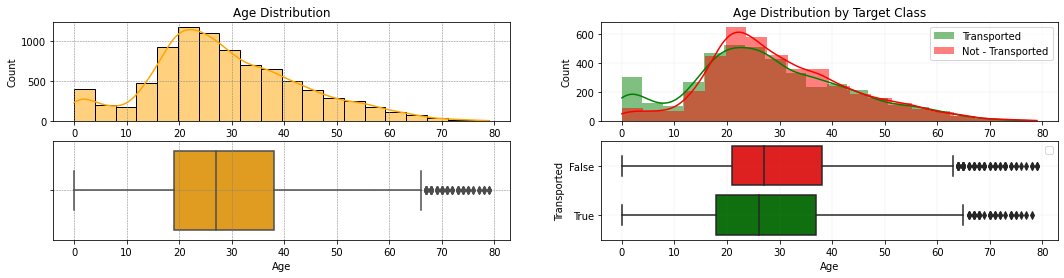

In [8]:
num_eda(df,"Age","Transported",20)

From the graph above is the distribution of the age of passengers, it can be seen that on the histogram graph on the right, more passengers aged 0-20 were transported, at the age of 20-40 more passengers were not transported, while those aged 40 and over tended to be the same.

<a id="roomservice"></a>
### Room Service, SPA, VR Deck

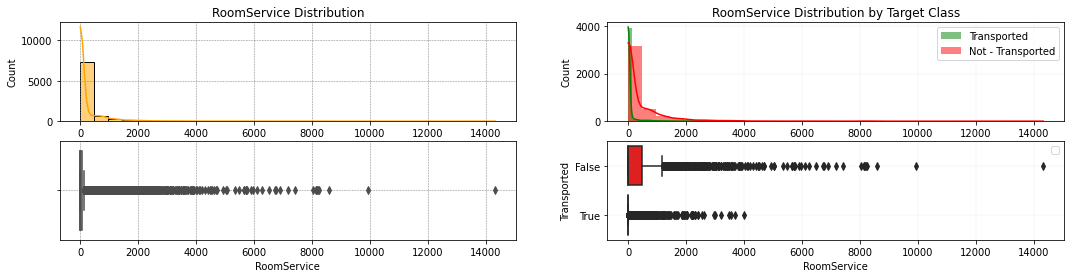

In [9]:
num_eda(df,"RoomService","Transported",30)

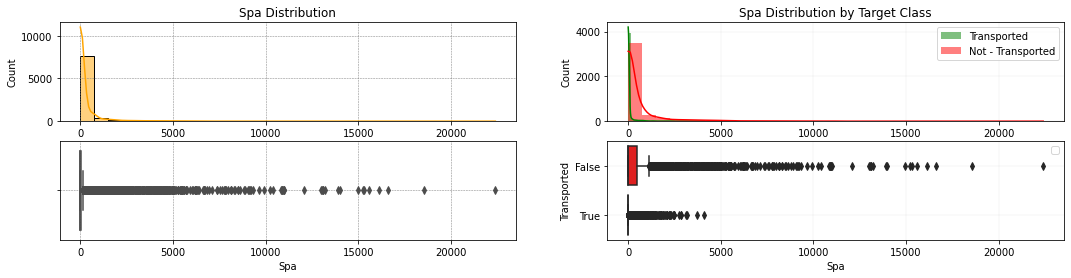

In [10]:
num_eda(df,"Spa","Transported",30)

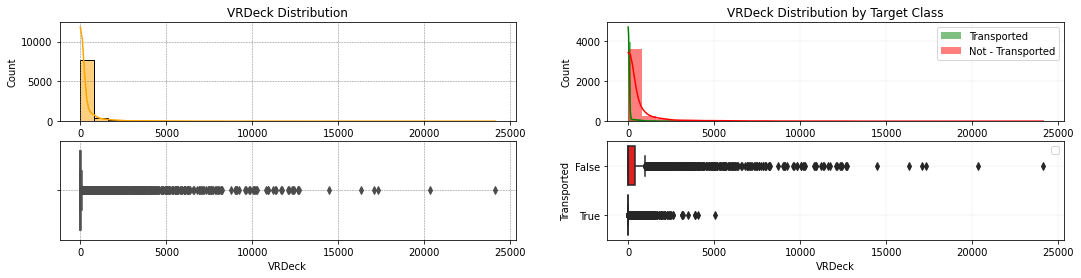

In [11]:
num_eda(df,"VRDeck","Transported",30)

In the graph above, passengers who spend big on Room Service, Spa, and VR Deck, are passengers who are not transported. We can see from the boxplot that in these three features (RoomService, Spa, and VRDeck), passengers who are Transported have a max value that is smaller than the max value of passengers who are not Transported.

<a id ="foodcourt"></a>
### Food Court, Shopping Mall

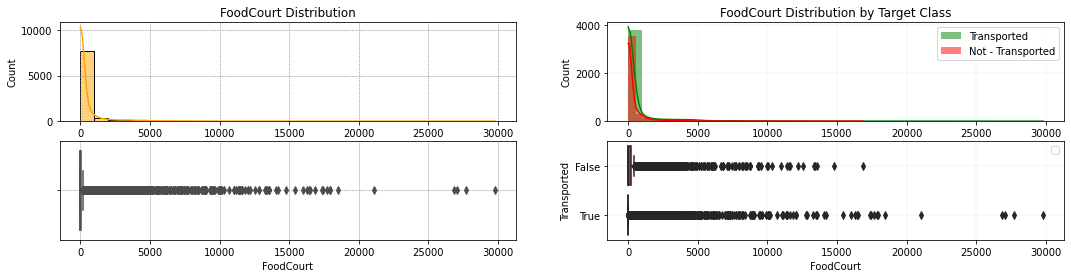

In [12]:
num_eda(df,"FoodCourt","Transported",30)

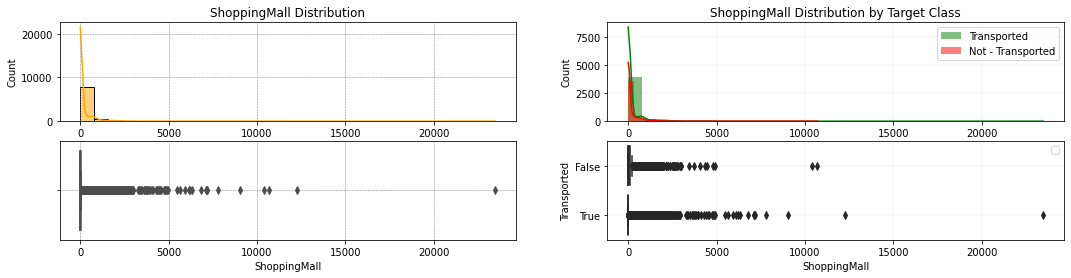

In [13]:
num_eda(df,"ShoppingMall","Transported",30)

In the graph above, there is no significant difference between Transported and Not Transported passengers regarding their spending on Food Courts and Shopping Malls.

## Total Bills And Percentage

In [14]:
def BillFeature(df):
    data = df.copy()
    Bills = ["RoomService","Spa","VRDeck","ShoppingMall","FoodCourt"]
    data[Bills] = data[Bills].fillna(0)
    data["TotalBills"] = data[Bills].sum(1)
    for Bill in Bills:
        data[Bill + "Perc"] = data[Bill].divide(data["TotalBills"])
        data[Bill + "Perc"] = data[Bill + "Perc"].fillna(0)
        
    return data

In [15]:
df = BillFeature(df)
df_test = BillFeature(df_test)

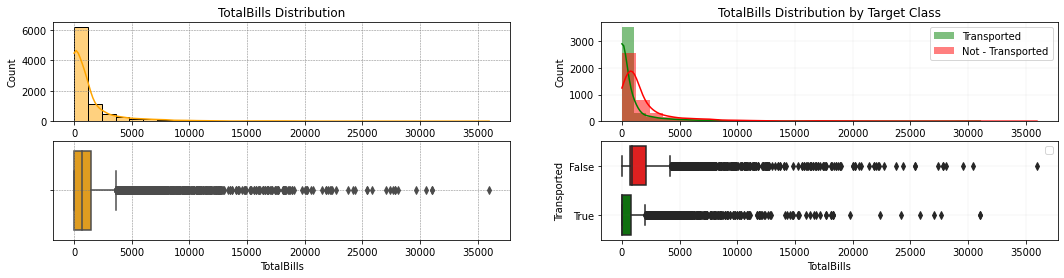

In [16]:
num_eda(df,"TotalBills","Transported",30)

After performing EDA on the numerical data, we find that five numerical features have asymmetrical distribution. Therefore, we will normalize the numerical data, which is expected to increase the score on the model. because there is a value of 0 in the data, we can't use the box-cox normalization so we will use the Yeo-Jonhson transformation method.

## Categorical Features

<a id = "unique"></a>
### Unique Values Count

In [17]:
df.select_dtypes(include = ["object","bool"]).nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
Transported       2
dtype: int64

From the information above, several categorical features have many unique values, namely `PassengerId`, `Cabin`, and `Name`. Because of that, we will do feature engineering on these features so that we can use these features with fewer unique numbers.

While for other category features, because the number of unique values ​​is small, we can use a one-hot encoder or label encoder.

In [18]:
#plot categorical Data (classification Task)
def cat_eda(data,feature,target):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1 = sns.countplot(x=feature, data=data, ax=axes[0],color = "orange",edgecolor = "k")
    ax1.bar_label(ax1.containers[0])
    ax1.set_title(f"{feature} Distribution")
    
    ax2 = sns.countplot(x = feature,hue = target, data = data,ax = axes[1],palette = ["r",'lime'],edgecolor = "k")
    ax2.set_title(f"{feature} Distribution with target")
    ax2.bar_label(ax2.containers[0])
    ax2.bar_label(ax2.containers[1])

<a id="homeplanet"></a>
### Home Planet

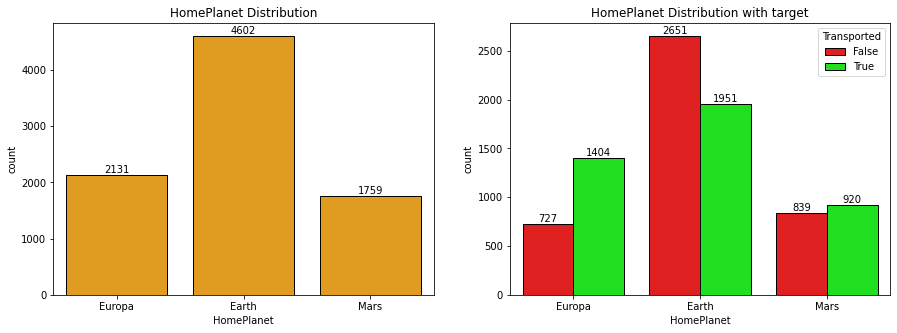

In [19]:
cat_eda(df,"HomePlanet","Transported")

Passengers come from 3 planets, namely Europa, Earth, and Mars. Most passengers come from Earth. The passenger with the highest percentage transported is Europa, Earth has the lowest percentage of transported passengers, while Mars has the same rate of Not Transported and Transported.

<a id="destination"></a>
## Destination

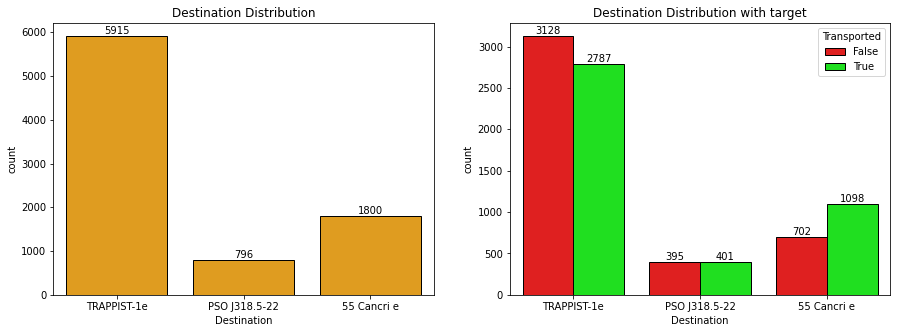

In [20]:
cat_eda(df,"Destination","Transported")

There are three destination planets, namely TRAPPIST-1e, PSO J318.5-22, and 55 Cancri e. Most passengers go to TRAPPIST-1e. Passengers with the highest percentage transported are Passengers who go to 55 Cancri e, while TRAPPIST-1e is the lowest percentage of passengers who are Transported. PSO J318.5-22 has the same Not Transported and Transported rates.


### Cryo Sleep

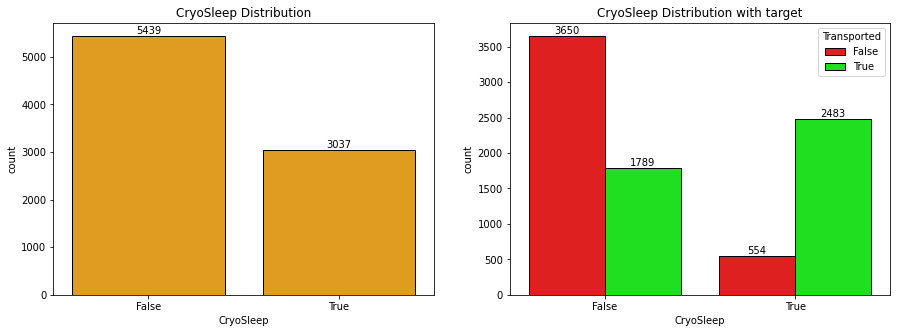

In [21]:
cat_eda(df,"CryoSleep","Transported")

Many passengers choose not to do Cryo Sleep. However, passengers who have the highest percentage of Not Transported are passengers who do not choose to do Cryo Sleep.


### VIP

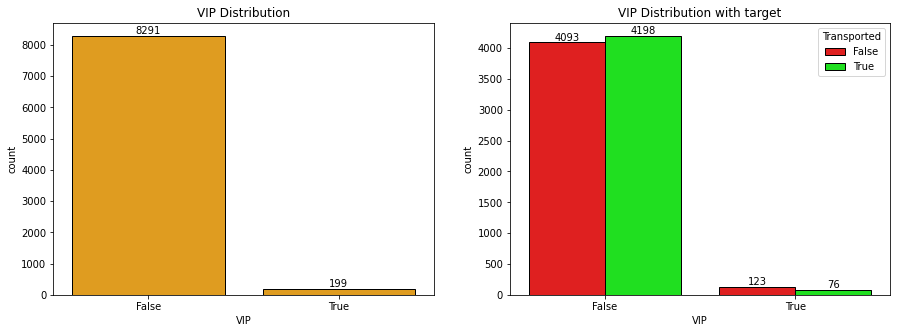

In [22]:
cat_eda(df,"VIP","Transported")

Based on this data, it turns out that not many passengers have VIP access. Only 199 people out of 8693 have VIP access. Regarding the percentage of Transported and Not Transported, there is not much difference between passengers who have VIP access and those who don't.


## Cabin

Previously we know that `Cabin` has many unique values. Therefore we need feature engineering in `Cabin`.

The nomenclature explains that `Cabin` consists of three parts of information: Deck, Number, and Side. A "/" sign separates all three parts of information, and We will create a new feature by splitting the Cabin into these three pieces of information.

In [23]:
df[["Deck","Number","Side"]] = df.Cabin.str.split("/",expand = True)
df_test[["Deck","Number","Side"]] = df_test.Cabin.str.split('/',expand = True)
df[["Deck","Number","Side"]].nunique()

Deck         8
Number    1817
Side         2
dtype: int64

After splitting into three parts, we now get a new feature called Deck, Number, and Side, which totalled eight unique values, Number summing 1817 unique values, and Side totalling two unique values. Because of that, we only use Deck and Side features.

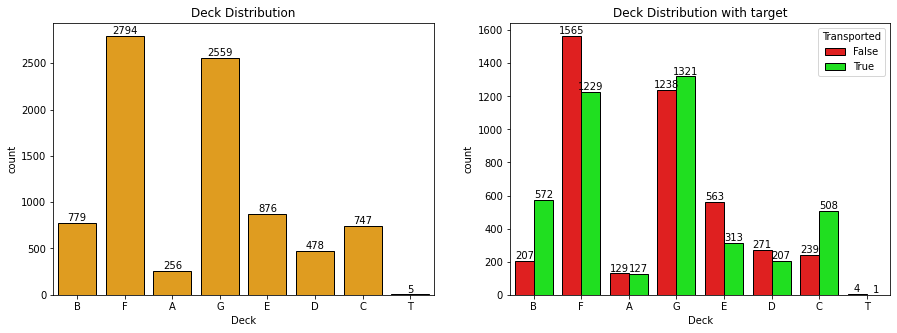

In [24]:
cat_eda(df,"Deck","Transported")

Cabins filled with many passengers are Cabin F and G, which are filled with around 2500 passengers, while the other cabins are filled with less than 1000 passengers.

Cabins B and C have a higher number of transported passengers. Cabins F and E have a higher number of Not Transported passengers than the Transported ones. In contrast, the rest of the cabins (A, D, G, T) have almost the same proportion between Transported and Not Transported.

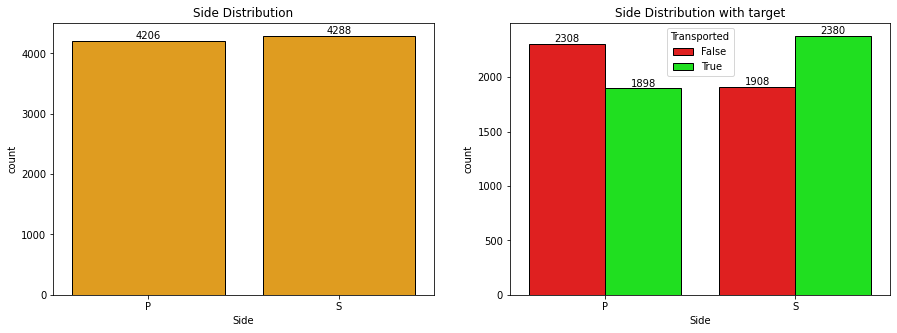

In [25]:
cat_eda(df,"Side","Transported")

Side P is for Port, and S is Starboard. Both have the same number of passengers. However, it has a different number of Not Transported and Transported. On Side P, the number of Not Transported is more than Transported, while on Side S, the number of Transported is more than Not Transported.

# Passenger Id

In `PassengerId`,  there are many unique values. Therefore we need feature engineering on this feature.

`PassengerId` has the following value format, `gggg_pp` contains two pieces of information, namely 'gggg' for the passenger number and 'pp' as the number of groups for that passenger. We will take the value of `pp` as a new feature.

After feature engineering, we find that `Group` or `pp` has several unique values of 8.

In [26]:
df[["Number","Group"]] = df.PassengerId.str.split("_",expand = True)
df_test[["Number","Group"]] = df_test.PassengerId.str.split("_",expand = True) 
df[["Number","Group"]].nunique()

Number    6217
Group        8
dtype: int64

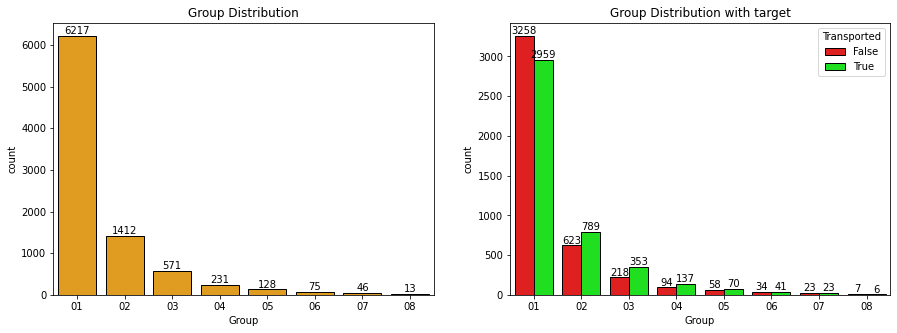

In [27]:
cat_eda(df,"Group","Transported")

## Name

In [28]:
#get the name length 
df["name_length"] = df.Name.str.len()
df_test["name_length"] = df_test.Name.str.len()
#get the first name and last name length
df[["first_length","last_length"]] = df.Name.str.split(" ",expand = True)
df["first_length"] = df.first_length.str.len()
df["last_length"] = df.last_length.str.len()

df_test[["first_length","last_length"]] = df_test.Name.str.split(" ",expand = True)
df_test["first_length"] = df_test.first_length.str.len()
df_test["last_length"] = df_test.last_length.str.len()

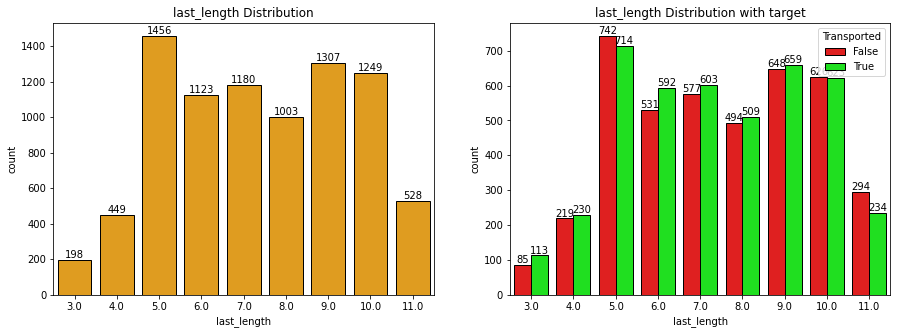

In [29]:
cat_eda(df,"last_length","Transported")

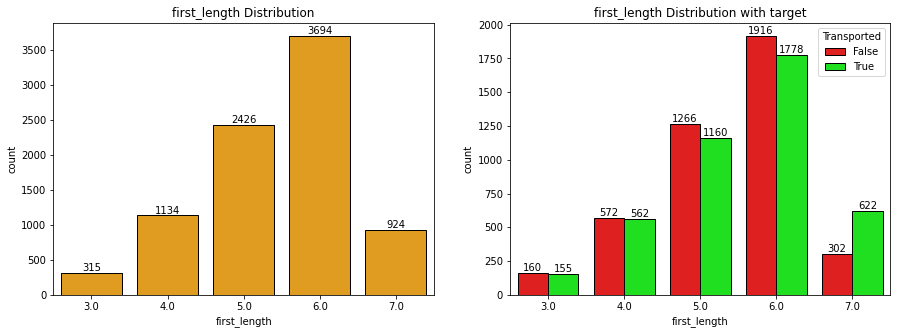

In [30]:
cat_eda(df,"first_length","Transported")

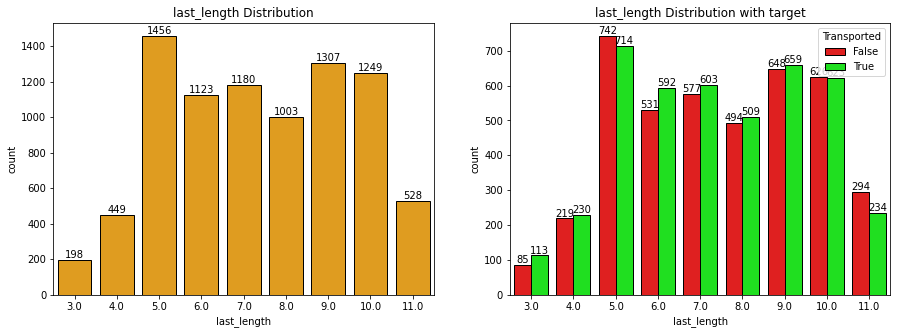

In [31]:
cat_eda(df,"last_length","Transported")

<a id = "corr"></a>
## Correlation Matrix

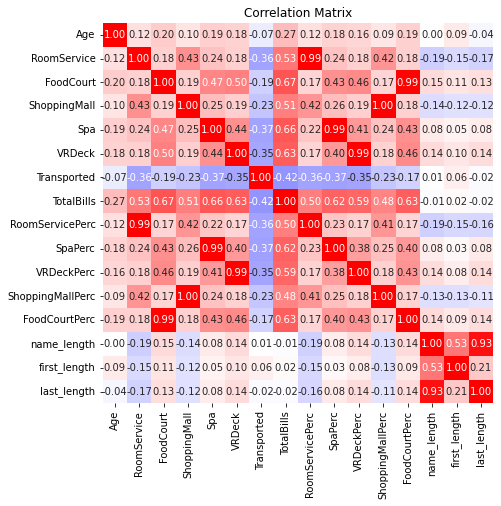

In [32]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(method="spearman"),cmap = "bwr" ,vmin = -1,vmax=1,annot = True,cbar = False,fmt = ".2f")
plt.title("Correlation Matrix");

<a id = "target"></a>
## Target Distribution

<AxesSubplot:ylabel='Transported'>

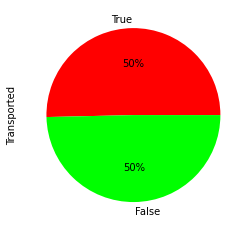

In [33]:
df.Transported.value_counts().plot(kind = "pie",autopct='%1.0f%%',colors = ["r","lime" ])

The pie chart above shows that the proportion of Transported and Not Transported is the same. Because the ratio of positive and negative classes in this dataset is balanced, we can use metric accuracy

<a id = "missing"></a>
## Missing Value Distribution

<Figure size 576x288 with 0 Axes>

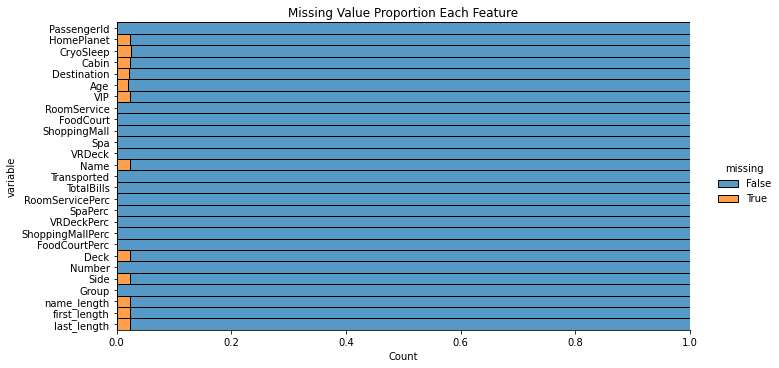

In [34]:
plt.figure(figsize=(8,4))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=2
)
plt.title("Missing Value Proportion Each Feature");

The graph above shows the proportion of missing values ​​in each feature. Because the ratio is not more than 0.1, each feature with a missing value will be imputed. However, because the data has an asymmetric distribution, imputation using the mean will not be used. Therefore imputation using the median will be more suitable.

At the End of EDA, we removed three built-in features from the dataset, namely `PassengerId`, `Cabin`, and `Name`. However, we added 12 new features from the `Cabin` and `PassengerId` features. So the final total of the features we will use is 22.

<a id = "modelling"></a>
# 3. Modelling

<a id = "datapar"></a>
## Create Train set and Test set
The data partition we will use here is the Train-Validation-Test split, where we will divide 80% of the data into Train Sets and 20% into Test Sets.

We will use The train set in this notebook for training and evaluation using the Stratified K-Fold Cross Validation method. Meanwhile, we use the test set for evaluation at the end of the modelling.

In [35]:
## stratified shuffle
X = df.drop(columns=["Transported","Number","PassengerId","Cabin","Name"])
y = df.Transported
y = y.apply(lambda x : 1 if x == True else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6954, 22), (1739, 22), (6954,), (1739,))

<a id = "prep"></a>
## Preprocessing
Next, we will create a Pipeline for the Preprocessing process. Here I made two pipelines, namely pipelines for numerical features and categorical features.

In the numerical pipeline, I do two steps: first, impute the missing values, and next, transform the features using the Yeo-Johnson method. I also did two phases in the categorical pipeline, imputation and the One-Hot-Encoder to change the categorical feature into a number.

In [36]:
def prep_pipeline(X_train,numerical_columns = "default",categorical_columns = "default"):
    if numerical_columns == "default":
        numerical_columns = X_train.select_dtypes(include = ["float64"]).columns

    if categorical_columns == "default": 
        categorical_columns = X_train.select_dtypes(include = ["object"]).columns  
        
    numeric_transformer = Pipeline(steps = [
        ("impute", SimpleImputer(strategy = "median")),
        ("Transform",PowerTransformer())
    ])

    categorical_transformer = Pipeline(steps=[
        ("impute",SimpleImputer(strategy="most_frequent")),
        ("encoder",OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(transformers = [
        ("numerical",numeric_transformer,numerical_columns),
        ("categorical",categorical_transformer,categorical_columns)
    ])
    return preprocessor
preprocessor = prep_pipeline(X_train)

<a id = "spot_check"></a>
## Spot Check Model

For the training model, I use several models, both simple models to complex models. The models that I will use in this notebook are Logistics Regression, KNN, SVM, Random Forest, LGM, XGBoost, and CatBoost. I will take three candidate models that have a high Cross Validation score, and then I will do Model Tuning.

In [37]:
df_model = pd.DataFrame(columns = ["model","set_data","score"])
set_data = ["test","train"]
models = {
        "KNN" : KNeighborsClassifier(),
        "SVM":SVC(),
        "Random Forest":RandomForestClassifier(random_state = 42,n_jobs = -1),
        "Logistic Regression" : LogisticRegression(random_state = 42), 
        "LGBM" : LGBMClassifier(random_state = 42),
        "XGB" : XGBClassifier(random_state = 42),
        "CatB" : CatBoostClassifier(random_state = 42,verbose = 0)
        }

scorer = "accuracy"
num_cv = 5
cv = StratifiedKFold(n_splits = num_cv,shuffle = True,random_state = 42)

for m in models:
    pipeline = Pipeline([  
    ('prep', preprocessor), 
    ('algo', models[m])
])
    spot_check = cross_val_score(pipeline,X_train,y_train,cv = cv,scoring = scorer,n_jobs= -1 )
    spot_check = spot_check.mean()
    model = pipeline.fit(X_train,y_train)
    score = pipeline.score(X_test,y_test)
    model_list = [m] * 2
    tes = pd.DataFrame(list(zip(model_list,set_data,[score,spot_check])),columns = ["model","set_data","score"])
    df_model = pd.concat([df_model,tes],ignore_index = True)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


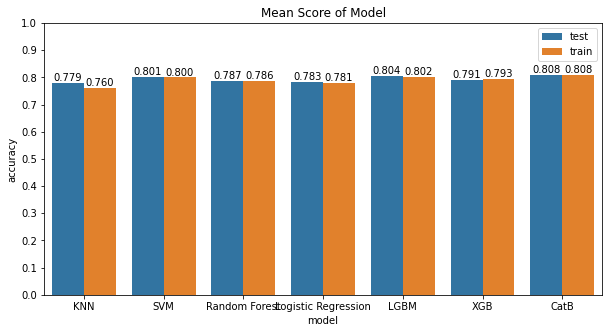

In [38]:
#set figsize
plt.figure(figsize=(10, 5))
plots = sns.barplot(x="model", y="score", data=df_model, ci=None,hue = "set_data")
plots.set_title("Mean Score of Model")
plots.bar_label(plots.containers[0],fmt = "%.3f")
plots.bar_label(plots.containers[1],fmt = "%.3f")
plt.yticks(np.arange(0,1.1,step = 0.1))
plt.ylabel("accuracy")
plt.legend();

The graph above shows that the average model has a score between 0.77 - 0.80. with the highest model equal to 0.808 for the Train score and 0.808 for the test score. We will take three models with a high score which we will then tune. The selected models are LGBM, XGBoost, and CatBoost.  

<a id = "tune"></a>
## Model Tuning Use Bayesian Search

## LGBM and XGBost

In [39]:
models_tune = {
    "CatBoost": CatBoostClassifier(random_state=42,verbose = 0),
    "LGBM": LGBMClassifier(random_state=42),
    "XGB": XGBClassifier(random_state=42)
}

#model parameters
params_catboost = {
    "algo__learning_rate": Real(low=0.001, high=1, prior='log-uniform', transform='identity'),
    "algo__max_depth": Integer(low=2, high=7, transform='identity'),
    "algo__l2_leaf_reg": Real(low=0.001, high=100, prior='log-uniform', transform='identity'),
}

params_lgbm = {
    'algo__max_depth': Integer(low=3, high=12, transform='identity'),
    'algo__learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='identity'),
    'algo__colsample_bytree': Real(low=0.1, high=1, transform='identity'),
    'algo__subsample': Real(low=0.2, high=0.8, transform='identity'),
    'algo__num_leaves': Integer(low=20, high=3000, transform='identity'),
    'algo__reg_alpha': Real(low=0.001, high=100, prior='log-uniform', transform='identity'),
    'algo__reg_lambda': Real(low=0.001, high=100, prior='log-uniform', transform='identity')
}

params_xgb = { 
 'algo__gamma': Integer(low=1, high=10, prior='uniform', transform='identity'),
 'algo__learning_rate': Real(low=0.01, high=1, prior='log-uniform', transform='identity'),
 'algo__max_depth': Integer(low=1, high=12, prior='uniform', transform='identity'),
 'algo__reg_alpha': Real(low=0.001, high=100, prior='log-uniform', transform='identity'),
 'algo__reg_lambda': Real(low=0.001, high=100, prior='log-uniform', transform='identity'),
 }

models_params = dict(zip(models_tune, [params_catboost, params_lgbm, params_xgb]))

In [40]:

model_dict = {}

for model in models_tune:
        pipeline = Pipeline([
                ("prep" , preprocessor),
                ("algo",models_tune[model])
        ])

        model_dict[model] = BayesSearchCV(pipeline,models_params[model], cv=5, scoring='accuracy', n_iter=20, n_jobs=-1, verbose=0, random_state=42)
        model_dict[model].fit(X_train, y_train)

        print(model)
        print("Best parameters found on training set:")
        print(model_dict[model].best_params_)
        print("Best score found on training set, validation set, and test set :")
        print(model_dict[model].score(X_train, y_train), model_dict[model].best_score_, model_dict[model].score(X_test, y_test))

CatBoost
Best parameters found on training set:
OrderedDict([('algo__l2_leaf_reg', 9.948719998234102), ('algo__learning_rate', 0.02061045404501547), ('algo__max_depth', 5)])
Best score found on training set, validation set, and test set :
0.8455565142364107 0.807593729473646 0.8159861989649224
LGBM
Best parameters found on training set:
OrderedDict([('algo__colsample_bytree', 0.6553714226520847), ('algo__learning_rate', 0.21188154764215272), ('algo__max_depth', 6), ('algo__num_leaves', 2625), ('algo__reg_alpha', 0.9185406410454461), ('algo__reg_lambda', 0.9399400944575313), ('algo__subsample', 0.5892665058222355)])
Best score found on training set, validation set, and test set :
0.8904227782571182 0.7976729127122457 0.7924094307073031
XGB
Best parameters found on training set:
OrderedDict([('algo__gamma', 10), ('algo__learning_rate', 0.2519085390684862), ('algo__max_depth', 11), ('algo__reg_alpha', 0.11997905526202189), ('algo__reg_lambda', 0.08041254806279295)])
Best score found on tr

# Submission

In [41]:
prediction = model_dict["CatBoost"].predict(df_test)
prediction = (prediction == 1)
my_submission = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': prediction})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [42]:
my_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True
